In [1]:
import requests
import time
import datetime
from tqdm.notebook import tqdm
import re
import numpy as np
import pandas as pd
import seaborn as sns; sns.set() # sns.set() ==> グラフの見た目をseabornに合わせる
from collections import Counter
from sklearn import preprocessing

import lightgbm as lgb
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score

import optuna.integration.lightgbm as lgb_o

import matplotlib.pyplot as plt
%matplotlib inline
# フォントの指定
#plt.rcParams['font.family'] = 'IPAexGothic'

In [5]:
df_seiseki = pd.read_csv('SEIDEKI2015-2020-complete.csv')
#df_seiseki = pd.read_csv('horse_data_2015-2020_base6.csv')

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df_seiseki.info()
#df_seiseki['単勝オッズ'].max() # 999.9

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293841 entries, 0 to 293840
Data columns (total 64 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   年              293841 non-null  int64  
 1   月              293841 non-null  int64  
 2   日              293841 non-null  int64  
 3   日付S            293841 non-null  object 
 4   回次             293841 non-null  int64  
 5   場所             293841 non-null  object 
 6   日次             293841 non-null  object 
 7   レース番号          293841 non-null  int64  
 8   レースID(新)       293841 non-null  int64  
 9   略レース名          293841 non-null  object 
 10  クラスコード         293841 non-null  int64  
 11  芝・ダ            293841 non-null  object 
 12  トラックコード        293841 non-null  int64  
 13  コーナー回数         284401 non-null  float64
 14  距離             293841 non-null  int64  
 15  コース区分          146457 non-null  object 
 16  馬場状態           293841 non-null  object 
 17  天候             293841 non-nul

In [7]:
#df_seiseki.dropna(subset=['人気'], inplace=True)
df_seiseki_drop = df_seiseki[df_seiseki['確定着順'] != 0]
df_seiseki_drop['確定着順'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

(確定着順      1.000000
 単勝オッズ    10.355998
 dtype: float64,
 確定着順      2.000000
 単勝オッズ    14.719232
 dtype: float64,
 確定着順      3.000000
 単勝オッズ    20.345159
 dtype: float64)

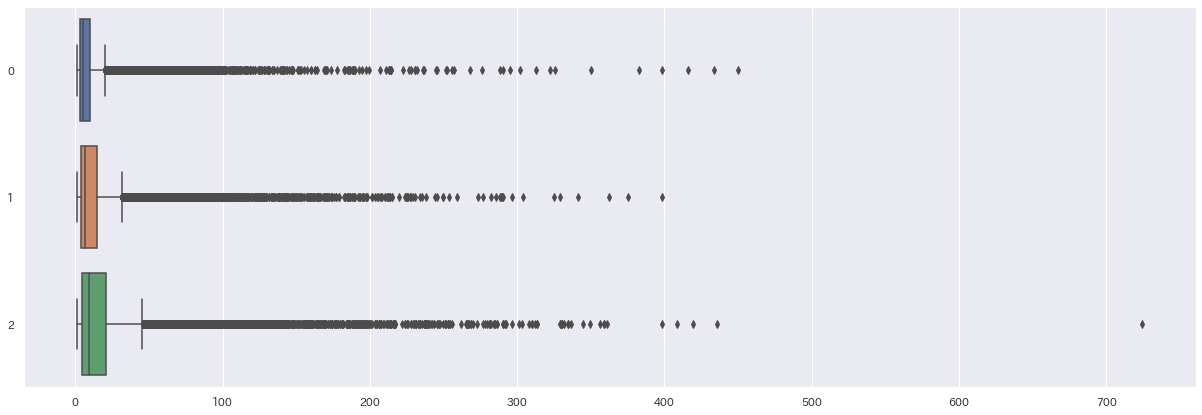

In [8]:
df_order1 = df_seiseki.query('確定着順==1')[['確定着順', '単勝オッズ']] # 1着のデータだけ取り出し
df_order2 = df_seiseki.query('確定着順==2')[['確定着順', '単勝オッズ']] # 1着のデータだけ取り出し
df_order3 = df_seiseki.query('確定着順==3')[['確定着順', '単勝オッズ']] # 1着のデータだけ取り出し

sns.set(rc = {'figure.figsize':(21,7)})
#sns.boxplot(data=[df_order1['単勝オッズ'].values, df_order2['単勝オッズ'].values, df_order3['単勝オッズ'].values], whis=np.inf) # his=np.inf ハズレ値を含んで髭が伸びる
sns.boxplot(data=[df_order1['単勝オッズ'].values, df_order2['単勝オッズ'].values, df_order3['単勝オッズ'].values], orient='h') # orient='h' h:横方向, v:縦方向

df_order1.mean(), df_order2.mean(), df_order3.mean()

<AxesSubplot:>

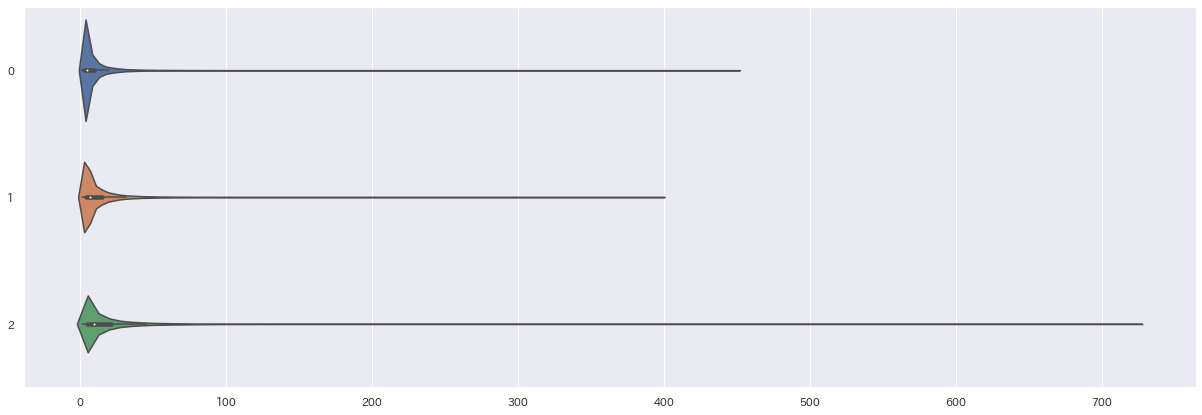

In [9]:
sns.violinplot(data=[df_order1['単勝オッズ'].values, df_order2['単勝オッズ'].values, df_order3['単勝オッズ'].values], orient='h', bw=0.05)

In [10]:
from numpy.random import randn
data1 = randn(100)
type(df_order1['単勝オッズ'].values)

numpy.ndarray

In [11]:
df_yearmonth = df_seiseki.query('確定着順==1')[['年', '月', '確定着順', '単勝オッズ']] # 1着のデータだけ取り出し
df_yearmonth = df_yearmonth.reset_index().drop(['index'], axis=1)
df_yearmonth

,年,月,確定着順,単勝オッズ
0,15,8,1,7.3
1,15,8,1,8.0
2,15,8,1,1.3
3,15,8,1,16.4
4,15,8,1,10.9
...,...,...,...,...
20751,20,9,1,2.3
20752,20,9,1,4.3
20753,20,9,1,5.8
20754,20,9,1,6.3


In [12]:
pivot = df_yearmonth.groupby(['年', '月']).mean()
pivot = pivot.reset_index()
pivot

,年,月,確定着順,単勝オッズ
0,15,1,1.0,11.251042
1,15,2,1.0,11.562319
2,15,3,1.0,10.832333
3,15,4,1.0,9.346970
4,15,5,1.0,11.372619
...,...,...,...,...
67,20,8,1.0,11.389457
68,20,9,1.0,9.675519
69,20,10,1.0,9.083113
70,20,11,1.0,11.271000


In [13]:
df_pivot = pivot.pivot(index='年', columns='月', values='単勝オッズ')
df_pivot

月,1,2,3,4,5,6,7,8,9,10,11,12
年,,,,,,,,,,,,
15,11.251042,11.562319,10.832333,9.346970,11.372619,10.677593,10.338194,9.944598,9.982083,9.884667,8.472667,10.848669
16,11.121406,9.391698,8.998264,11.821667,10.014950,12.651037,10.998056,11.590625,10.725926,9.886350,8.901141,12.375610
17,11.133333,12.109848,10.597222,11.362500,9.809057,9.302075,9.038227,10.888889,9.471970,9.564744,9.446008,12.832292
18,10.131142,9.026996,9.938339,12.128526,10.039245,10.016667,9.357407,9.673356,9.778623,11.212583,8.796958,9.736111
19,9.915530,11.006574,10.884273,9.760900,11.017625,9.907051,8.389931,8.893210,9.361660,8.877083,10.326000,10.248810
20,11.239623,10.136111,11.556923,11.870189,9.234226,11.880682,10.906792,11.389457,9.675519,9.083113,11.271000,10.453962


<AxesSubplot:xlabel='月', ylabel='年'>

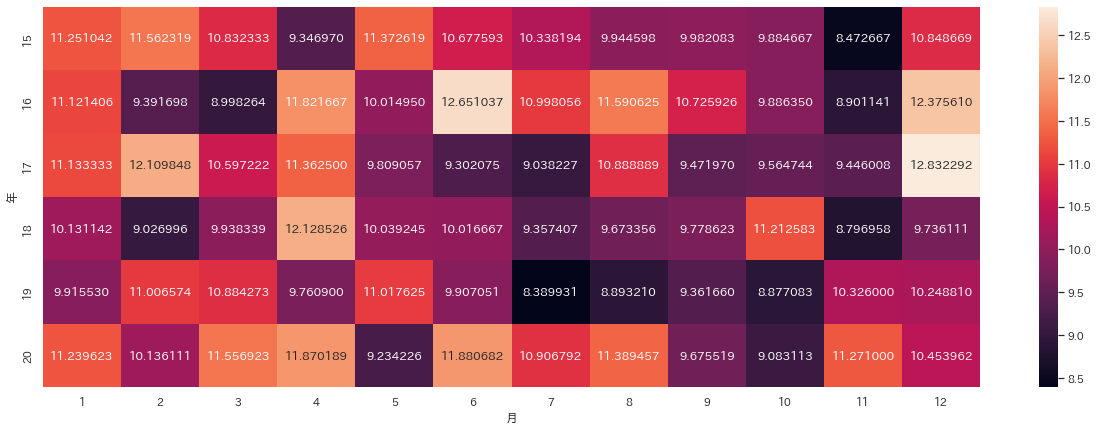

In [14]:
sns.heatmap(df_pivot,annot=True, fmt='f')
#sns.heatmap(df_pivot,annot=True, fmt='f', center=df_pivot.loc[17, 7])

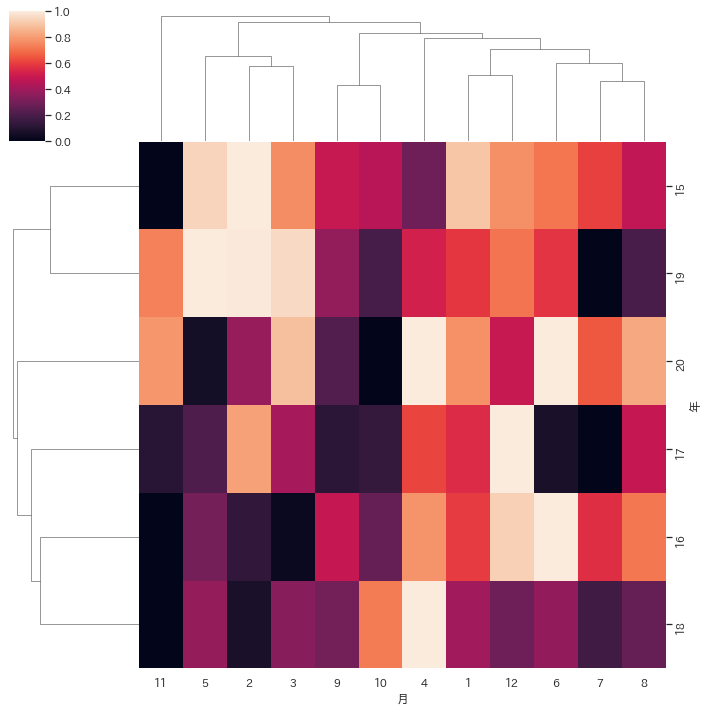

In [15]:
sns.clustermap(df_pivot, standard_scale=0)

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


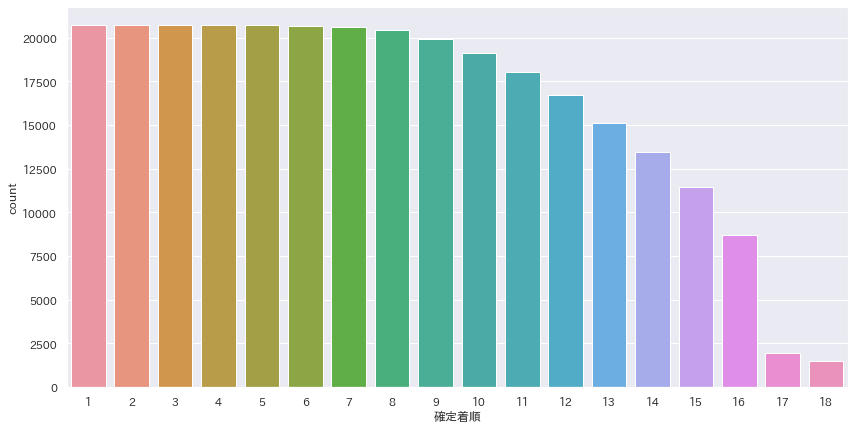

In [16]:
sns.set(rc = {'figure.figsize':(14,7)})
ax = sns.countplot('確定着順', data=df_seiseki_drop)

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


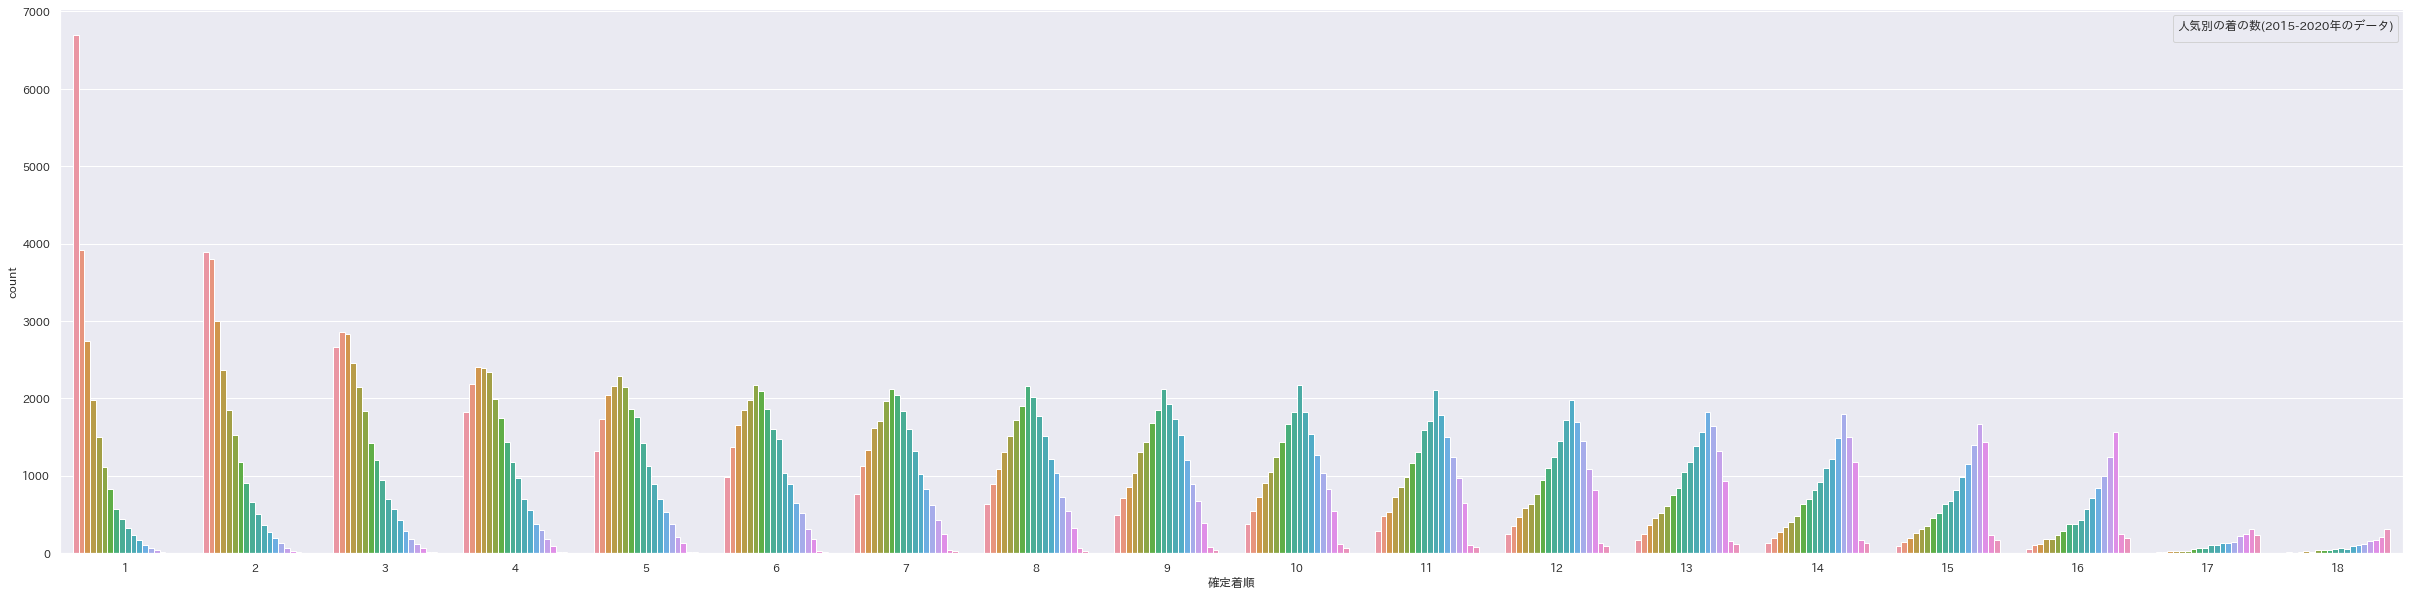

In [17]:
sns.set(rc = {'figure.figsize':(42,10)})
ax = sns.countplot('確定着順', data=df_seiseki_drop, hue='人気')
#sns.barplot(y="数", x='人気別着数', data=df_seiseki_drop)
plt.legend(labels=[], title = "人気別の着の数(2015-2020年のデータ)")

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


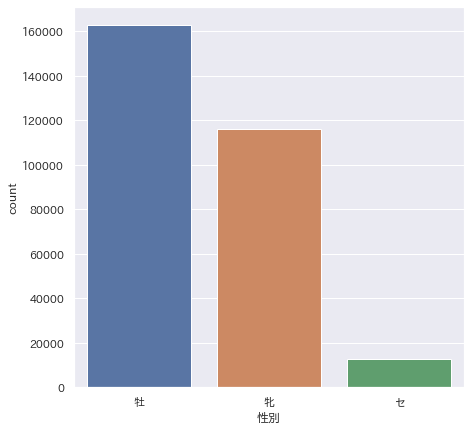

In [18]:
sns.set(rc = {'figure.figsize':(7,7)})
ax = sns.countplot('性別', data=df_seiseki_drop)


/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


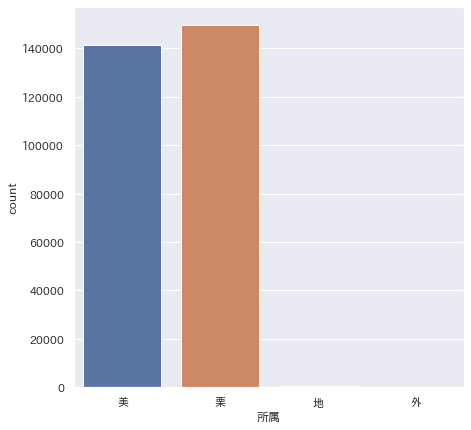

In [19]:
sns.set(rc = {'figure.figsize':(7,7)})
ax = sns.countplot('所属', data=df_seiseki_drop)


/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


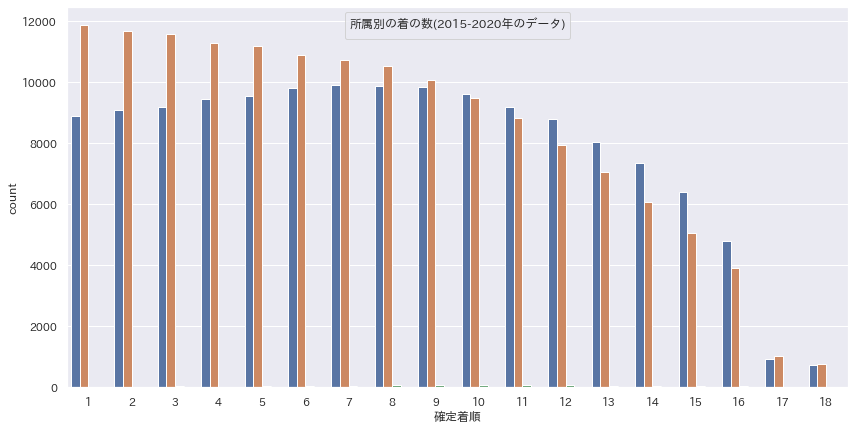

In [20]:
sns.set(rc = {'figure.figsize':(14,7)})
ax = sns.countplot('確定着順', data=df_seiseki_drop, hue='所属')
#sns.barplot(y="数", x='人気別着数', data=df_seiseki_drop)
plt.legend(labels=[], title = "所属別の着の数(2015-2020年のデータ)")

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


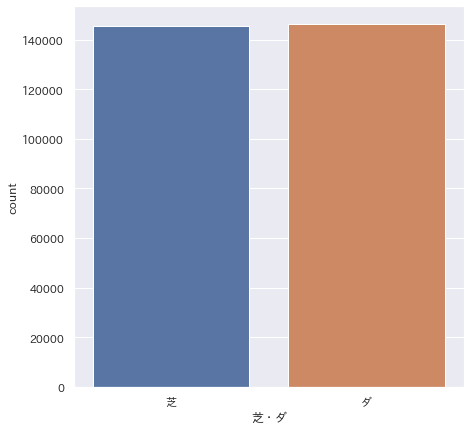

In [21]:
sns.set(rc = {'figure.figsize':(7,7)})
ax = sns.countplot('芝・ダ', data=df_seiseki_drop)

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


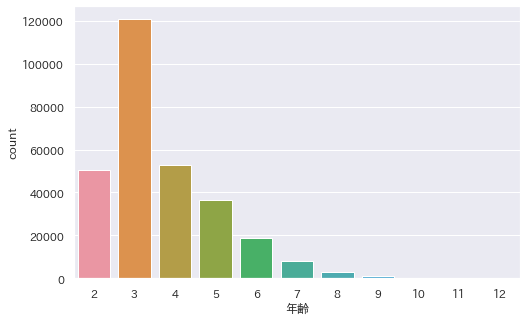

In [22]:
sns.set(rc = {'figure.figsize':(8,5)})
ax = sns.countplot('年齢', data=df_seiseki_drop)

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


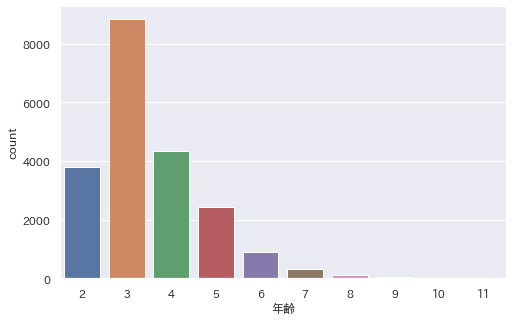

In [23]:
sns.set(rc = {'figure.figsize':(8,5)})
ax = sns.countplot('年齢', data=df_seiseki_drop.query('確定着順==1'))

In [24]:
tan_odds_bining = pd.cut(df_seiseki_drop['単勝オッズ'], [0, 2.5, 5, 10, 15, 20, 30, 50, 100, 1000])
tan_odds_bining

0            (10.0, 15.0]
1             (5.0, 10.0]
2           (50.0, 100.0]
3         (100.0, 1000.0]
4         (100.0, 1000.0]
               ...       
293836      (50.0, 100.0]
293837      (50.0, 100.0]
293838       (20.0, 30.0]
293839       (15.0, 20.0]
293840      (50.0, 100.0]
Name: 単勝オッズ, Length: 291440, dtype: category
Categories (9, interval[float64, right]): [(0.0, 2.5] < (2.5, 5.0] < (5.0, 10.0] < (10.0, 15.0] ... (20.0, 30.0] < (30.0, 50.0] < (50.0, 100.0] < (100.0, 1000.0]]

In [25]:
cross_tyaku = pd.crosstab(tan_odds_bining, [df_seiseki_drop['確定着順'], df_seiseki_drop['芝・ダ']])
cross_tyaku

確定着順               1           2           3           4           5         \
芝・ダ                 ダ     芝     ダ     芝     ダ     芝     ダ     芝     ダ     芝   
単勝オッズ                                                                         
(0.0, 2.5]       2000  2183  1044  1039   652   628   372   424   238   254   
(2.5, 5.0]       3117  3300  2651  2846  2063  2182  1546  1647  1153  1324   
(5.0, 10.0]      2557  2573  2682  2955  2601  2789  2348  2636  2071  2317   
(10.0, 15.0]      891   925  1210  1171  1265  1416  1366  1368  1332  1380   
(15.0, 20.0]      441   510   693   729   829   845   936   913   982  1021   
(20.0, 30.0]      498   470   735   729   960   952  1112  1200  1261  1199   
(30.0, 50.0]      339   324   583   541   840   845  1057  1058  1201  1283   
(50.0, 100.0]     231   220   385   402   602   619   900   810  1139  1048   
(100.0, 1000.0]   105    72   187   154   349   301   540   490   797   733   

確定着順             ...    13          14          15          16          17  \
芝・ダ              ...     ダ     芝     ダ     芝     ダ     芝     ダ     芝     芝   
単勝オッズ            ...                                                         
(0.0, 2.5]       ...    25    12    20    12    11     9     7     3     4   
(2.5, 5.0]       ...   166   140   135    98   105    69    61    46    14   
(5.0, 10.0]      ...   489   393   387   296   305   205   178   143    54   
(10.0, 15.0]     ...   425   341   342   287   267   194   161   161    58   
(15.0, 20.0]     ...   408   340   320   297   268   203   163   138    55   
(20.0, 30.0]     ...   706   590   531   499   463   358   271   274   101   
(30.0, 50.0]     ...   972   903   846   711   671   528   413   393   161   
(50.0, 100.0]    ...  1564  1343  1362  1106  1067   926   767   728   328   
(100.0, 1000.0]  ...  3464  2825  3486  2710  3236  2573  2467  2325  1163   

確定着順              18  
芝・ダ                芝  
単勝オッズ                 
(0.0, 2.5]         0  
(2.5, 5.0]        11  
(5.0, 10.0]       40  
(10.0, 15.0]      39  
(15.0, 20.0]      45  
(20.0, 30.0]      65  
(30.0, 50.0]     121  
(50.0, 100.0]    221  
(100.0, 1000.0]  948  

[9 rows x 34 columns]

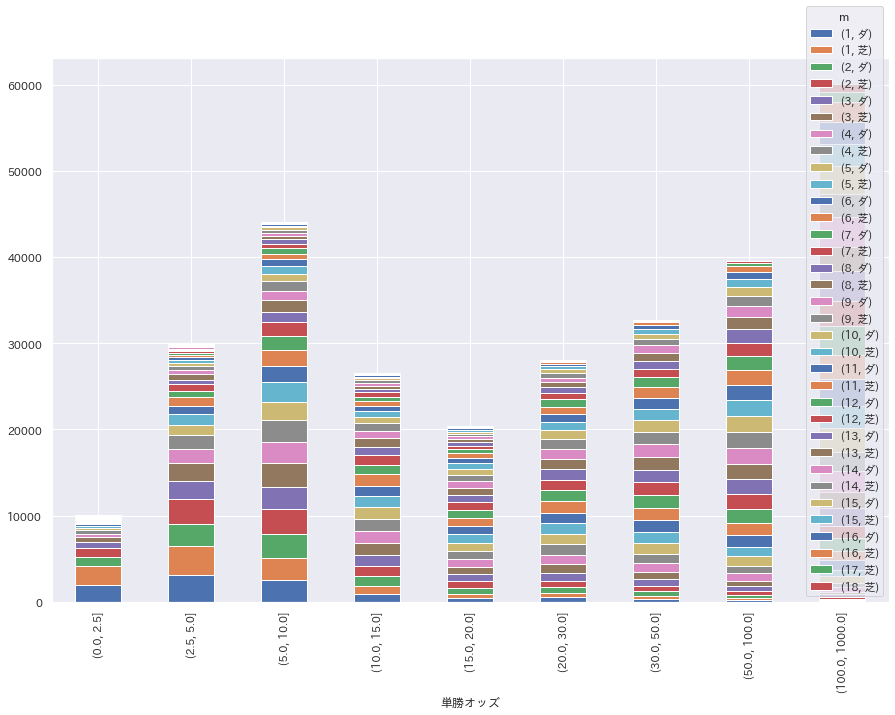

In [26]:
sns.set(rc = {'figure.figsize':(15,10)})
cross_tyaku.plot.bar(stacked=True)
#cross_tyaku.plot.bar()
plt.legend(title='m')
plt.show()

In [27]:
#df_seiseki_drop['場所'].unique()
cross_tyaku = pd.crosstab(tan_odds_bining, [df_seiseki_drop['確定着順'], df_seiseki_drop['場所'], df_seiseki_drop['芝・ダ']])
cross_tyaku.loc[:, 1]

場所                中京        中山        京都        函館        小倉        新潟       \
芝・ダ                ダ    芝    ダ    芝    ダ    芝    ダ    芝    ダ    芝    ダ    芝   
単勝オッズ                                                                         
(0.0, 2.5]       163  168  359  285  325  327   77  102   72  172  129  191   
(2.5, 5.0]       265  284  484  382  514  447  114  158  166  285  250  346   
(5.0, 10.0]      246  236  431  331  413  360   90  136  132  230  194  270   
(10.0, 15.0]      75  102  147  102  133  126   29   39   51   88   72  109   
(15.0, 20.0]      33   38   68   58   82   70   17   23   30   49   35   58   
(20.0, 30.0]      42   39   84   56  100   63   16   24   18   51   26   52   
(30.0, 50.0]      32   26   67   42   48   28   12   11   21   28   28   45   
(50.0, 100.0]     24   27   44   25   40   28    4    9   10   22   17   21   
(100.0, 1000.0]   10    3   17    6   20   13    4    3    5   10    3    6   

場所                札幌        東京        福島        阪神       
芝・ダ                ダ    芝    ダ    芝    ダ    芝    ダ    芝  
単勝オッズ                                                    
(0.0, 2.5]        73  118  354  371   90  115  358  334  
(2.5, 5.0]       123  168  533  522  169  260  499  448  
(5.0, 10.0]       82  117  391  349  182  233  396  311  
(10.0, 15.0]      34   42  143  112   47   97  160  108  
(15.0, 20.0]      12   25   68   66   25   55   71   68  
(20.0, 30.0]      25   23   94   67   23   41   70   54  
(30.0, 50.0]      11   17   41   46   21   30   58   51  
(50.0, 100.0]      6   10   32   29   15   27   39   22  
(100.0, 1000.0]    3    2   20   11    6    5   17   13

In [28]:
df_seiseki[['補9', '補正タイム']]

,補9,補正タイム
0,87.0,72.0
1,101.0,86.0
2,65.0,50.0
3,76.0,61.0
4,69.0,54.0
...,...,...
293836,102.0,92.0
293837,85.0,75.0
293838,63.0,53.0
293839,82.0,72.0


In [29]:
%%time
odds_max = 999.9

odds_data = df_seiseki[['レースID(新)', '頭数', '人気', '単勝オッズ', '確定着順']]
odds_data['race_id'] = odds_data['レースID(新)'].map(lambda x: str(x)[:16]) # レースごとのIDを作る(後ろ２バイトの馬番データを省く)
#df_select['race_id'] = df_select['race_id'].astype('category')
odds_data.drop(['レースID(新)'], axis=1, inplace=True)

i = 0
for index in odds_data['race_id'].unique():
    race_unit = odds_data.query('race_id==@index').sort_values('単勝オッズ')
    top_odds = race_unit['単勝オッズ'].min()
    #race_unit['odds_diff'] = race_unit['単勝オッズ'].map(lambda x: x - top_odds)
    #print(race_unit.sort_values('単勝オッズ'))
    race_unit['odds_diff'] = race_unit['単勝オッズ'].diff().fillna(0) # 1番人気にNaNが返されるので「0」をに置き換える
    race_unit['odds_rank'] = race_unit['単勝オッズ'].map(lambda x: odds_max - x)
    race_unit = race_unit.reindex(columns=[
                                    'race_id',
                                    '頭数',
                                    '人気',
                                    '単勝オッズ',
                                    'odds_diff',
                                    'odds_rank',
                                    '確定着順',
                                    ])
    #print(race_unit.sort_index()['odds_rank'])
    odds_data.loc[odds_data['race_id']==index, 'odds_rank'] = race_unit.sort_index()['odds_rank']
    #print(odds_data.loc[odds_data['race_id']==index])
    #if i > 0:
    #    break
    #i = i + 1
    
odds_data

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

CPU times: user 9min 2s, sys: 98.7 ms, total: 9min 2s
Wall time: 9min 3s


,頭数,人気,単勝オッズ,確定着順,race_id,odds_rank
0,10,6.0,14.7,6,2015080101010101,985.2
1,10,4.0,7.3,1,2015080101010101,992.6
2,10,7.0,90.1,10,2015080101010101,909.8
3,10,9.0,142.9,8,2015080101010101,857.0
4,10,10.0,235.2,9,2015080101010101,764.7
...,...,...,...,...,...,...
293836,15,15.0,98.5,2,2020090610020812,901.4
293837,15,12.0,62.2,9,2020090610020812,937.7
293838,15,9.0,24.7,15,2020090610020812,975.2
293839,15,8.0,19.8,12,2020090610020812,980.1


In [30]:
%%time
odds_max = 999.9

def truncate(str, num_bytes, encoding='utf-8'):
    while len(str.encode(encoding)) > num_bytes:
        str = str[:-1]
    return str

odds_data = df_seiseki[['レースID(新)', '頭数', '人気', '単勝オッズ', '確定着順']]
odds_data['race_id'] = odds_data['レースID(新)'].map(lambda x: str(x)[:16]) # レースごとのIDを作る(後ろ２バイトの馬番データを省く)
#df_select['race_id'] = df_select['race_id'].astype('category')
odds_data.drop(['レースID(新)'], axis=1, inplace=True)

i = 0
for index in odds_data['race_id'].unique():
    race_unit = odds_data.query('race_id==@index').sort_values('単勝オッズ')
    top_odds = race_unit['単勝オッズ'].min()
    #race_unit['odds_diff'] = race_unit['単勝オッズ'].map(lambda x: x - top_odds)
    #print(race_unit.sort_values('単勝オッズ'))
    race_unit['odds_diff'] = race_unit['単勝オッズ'].diff().fillna(0) # 1番人気にNaNが返されるので「0」をに置き換える
    race_unit['odds_rank'] = race_unit['単勝オッズ'].map(lambda x: odds_max - x)

    pattern = 0
    upper_horse = 0
    #counter = 0
    for odds in race_unit['単勝オッズ'].values:
        if upper_horse == 0:
            # １回目の処理
            # upper_horse = odds
            pass
        else:
            if odds >= upper_horse * 2:
                if pattern != 0:
                    pattern = pattern * 10
                #pattern = pattern + 1
                #counter = 0
            else:
                pass
        pattern = pattern + 1
                
        #print(odds)
        upper_horse = odds

    if len(str(pattern)) >= 4:
        print(truncate(str(pattern), 3))
    else:
        print(str(pattern).zfill(3))
    print('pattern = ',pattern)
    #race_unit['odds_fault']
    race_unit = race_unit.reindex(columns=[
                                    'race_id',
                                    '頭数',
                                    '人気',
                                    '単勝オッズ',
                                    'odds_diff',
                                    'odds_rank',
                                    '確定着順',
                                    ])
    #print(race_unit)
    #print(race_unit.sort_index()['odds_rank'])
    odds_data.loc[odds_data['race_id']==index, 'odds_rank'] = race_unit.sort_index()['odds_rank']
    #print(odds_data.loc[odds_data['race_id']==index])
    if i > 4:
        break
    i = i + 1
    #df_select.loc[df_select['race_id']==index, 'odds_pattern'] = str_pattern
    
#odds_data

064
pattern =  64
911
pattern =  9111
117
pattern =  117
461
pattern =  461
022
pattern =  22
175
pattern =  1752
CPU times: user 312 ms, sys: 27.9 ms, total: 340 ms
Wall time: 339 ms


/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

<AxesSubplot:title={'center':'Horse Data ペアプロット'}>

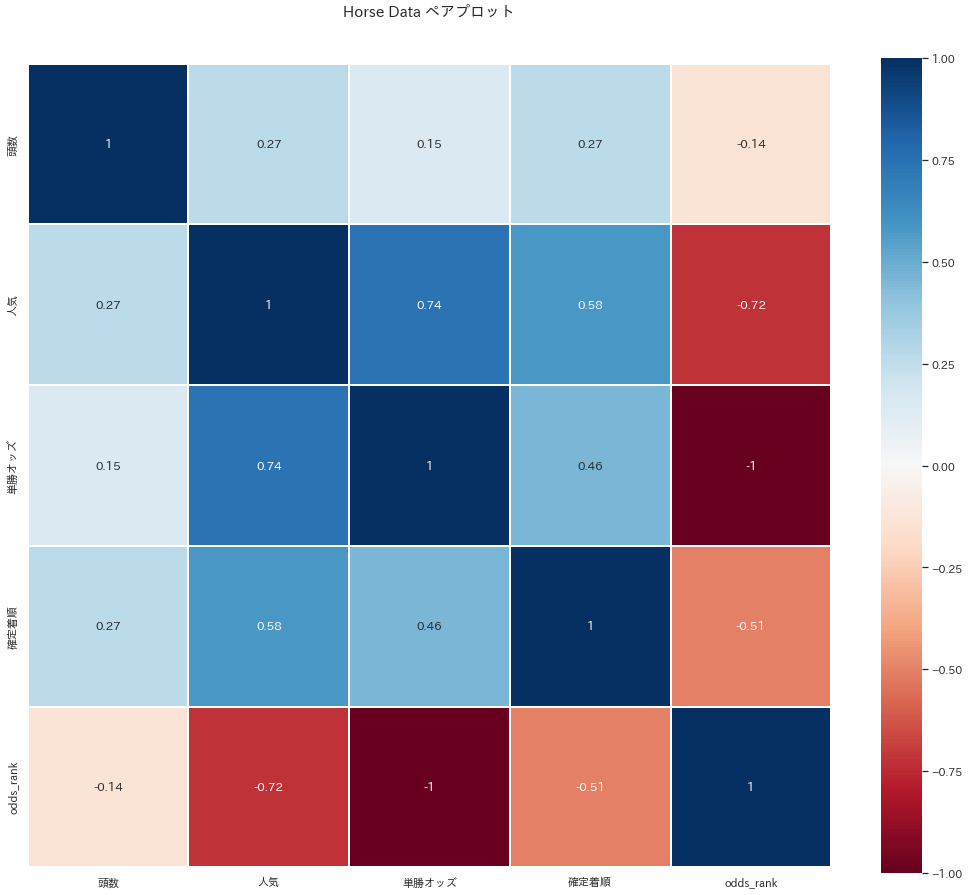

In [31]:
colormap = plt.cm.RdBu
plt.figure(figsize=(18, 15))
plt.title('Horse Data ペアプロット', y=1.05, size=15)
sns.heatmap(odds_data.corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

<AxesSubplot:title={'center':'Horse Data ペアプロット'}>

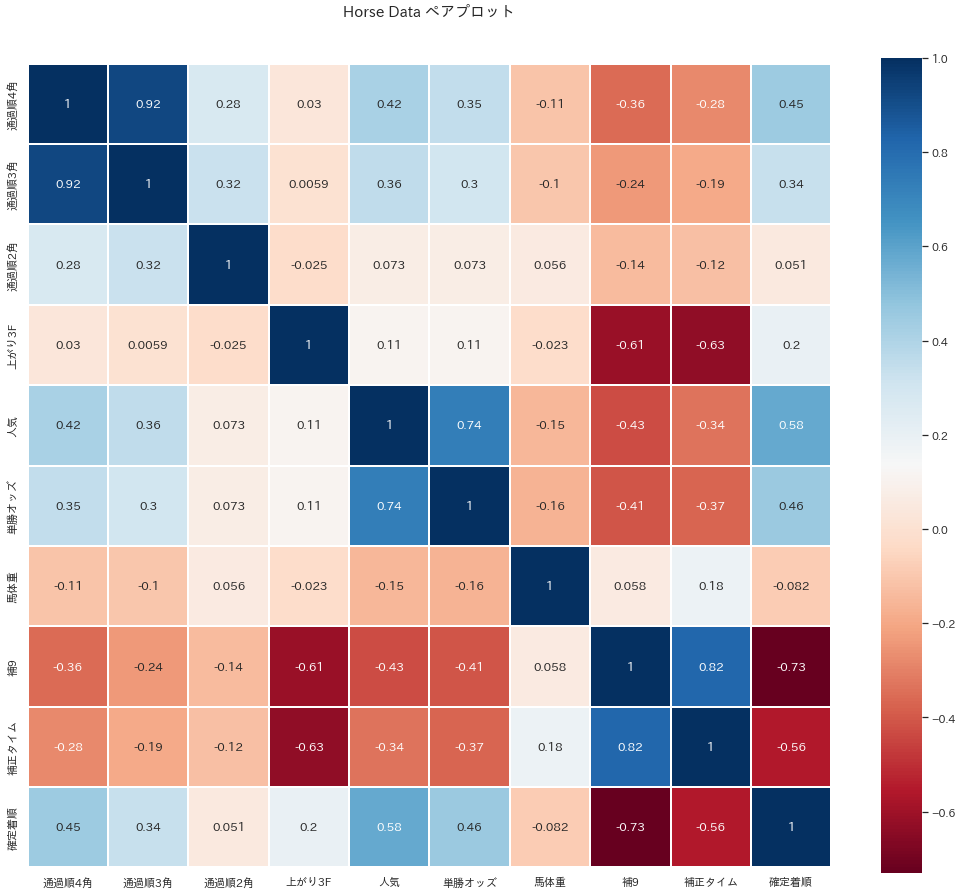

In [32]:
horse = df_seiseki[['通過順4角', '通過順3角', '通過順2角', '上がり3F', '人気', '単勝オッズ', '馬体重', '補9', '補正タイム', '確定着順', ]]
colormap = plt.cm.RdBu
plt.figure(figsize=(18, 15))
plt.title('Horse Data ペアプロット', y=1.05, size=15)
sns.heatmap(horse.corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

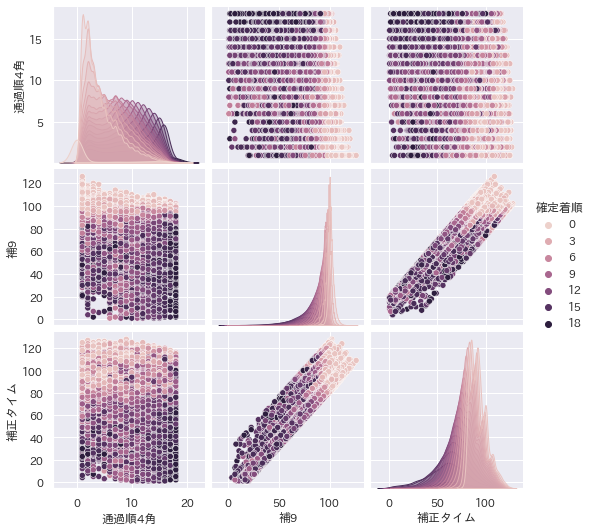

In [33]:
uma = df_seiseki[['確定着順', '通過順4角', '補9', '補正タイム', ]]
sns.pairplot(data=uma, vars=['通過順4角', '補9', '補正タイム'], hue='確定着順')

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


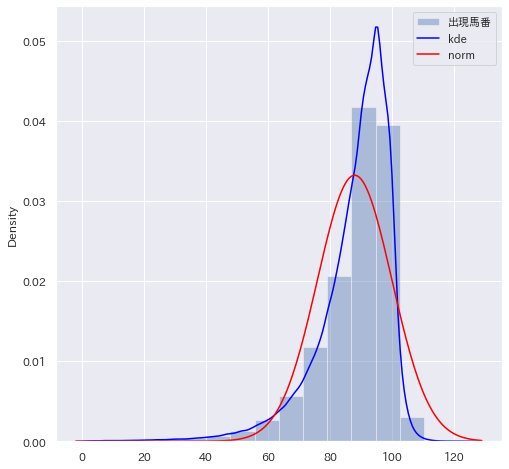

In [34]:
from pylab import rcParams
#import scipy
from scipy.stats import norm # 正規分布

rcParams['figure.figsize'] = 8, 8
plt.tight_layout() # グラフ同士が重ならないようにする関数

#df_seiseki[['確定着順', '馬番']]
count = 16
#sns.distplot(df_seiseki['補正タイム'].tolist(),
sns.distplot(df_seiseki['補9'].tolist(),
             kde=True,
             rug=False,
             fit=norm,
             bins=count,
             label='出現馬番',
             kde_kws={'color':'blue','label':'kde'},
             fit_kws={'label': 'norm','color':'red'})
plt.legend()
plt.show()


/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


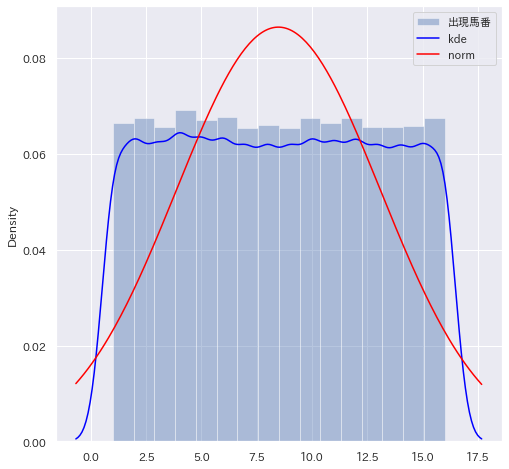

In [35]:
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
#import scipy
from scipy.stats import norm # 正規分布

rcParams['figure.figsize'] = 8, 8
plt.tight_layout() # グラフ同士が重ならないようにする関数

#df_seiseki[['確定着順', '馬番']]
count = 16
numbr = df_seiseki.query('頭数==@count')[['確定着順', '馬番']]
h = numbr.query('確定着順<=5')['馬番']
sns.distplot(h.tolist(),
             kde=True,
             rug=False,
             fit=norm,
             bins=count,
             label='出現馬番',
             kde_kws={'color':'blue','label':'kde'},
             fit_kws={'label': 'norm','color':'red'})
plt.legend()
plt.show()

#df_seiseki.query('確定着順<=5')['馬番'].value_counts()
#plt.hist(h.tolist(), bins=16, range=(1,16), color='Blue')
#plt.show()

#h.tolist()

In [36]:
# 設定ファイル情報
#import matplotlib as mpl
#mpl.matplotlib_fname()

CPU times: user 51.3 s, sys: 23 s, total: 1min 14s
Wall time: 45.9 s


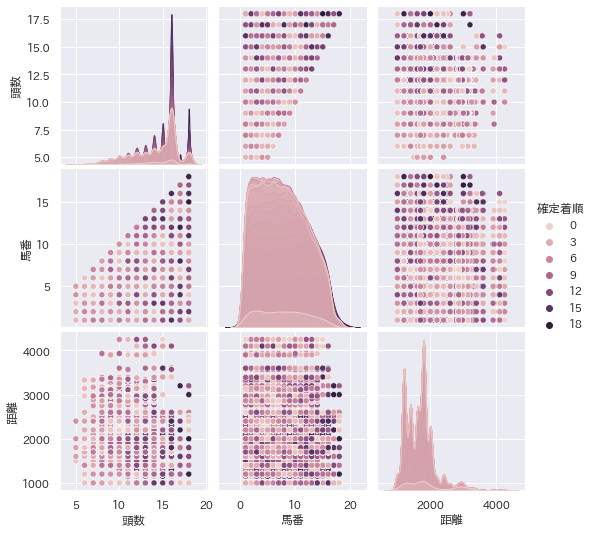

In [37]:
%%time
#place_status = df_seiseki[['場所', '距離', '芝・ダ']].value_counts()
#place_status.to_csv('競馬場基本データ.csv')

#df_seiseki['年齢'].unique()


numbr = df_seiseki[['頭数', '確定着順', '馬番', '距離']]
sns.pairplot(numbr, hue="確定着順") # hue：カテゴリ分けしたい列名を指定

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


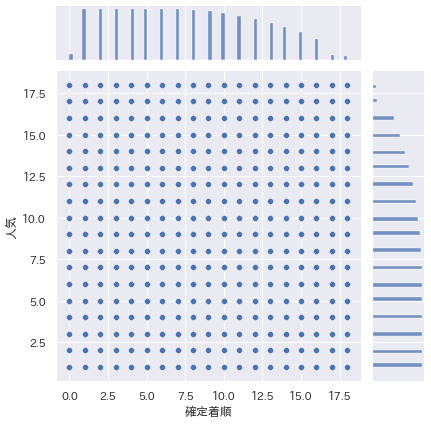

In [38]:
numbr = df_seiseki[['頭数', '人気', '確定着順', '馬番', '距離']]
sns.jointplot('確定着順', '人気', data=numbr)

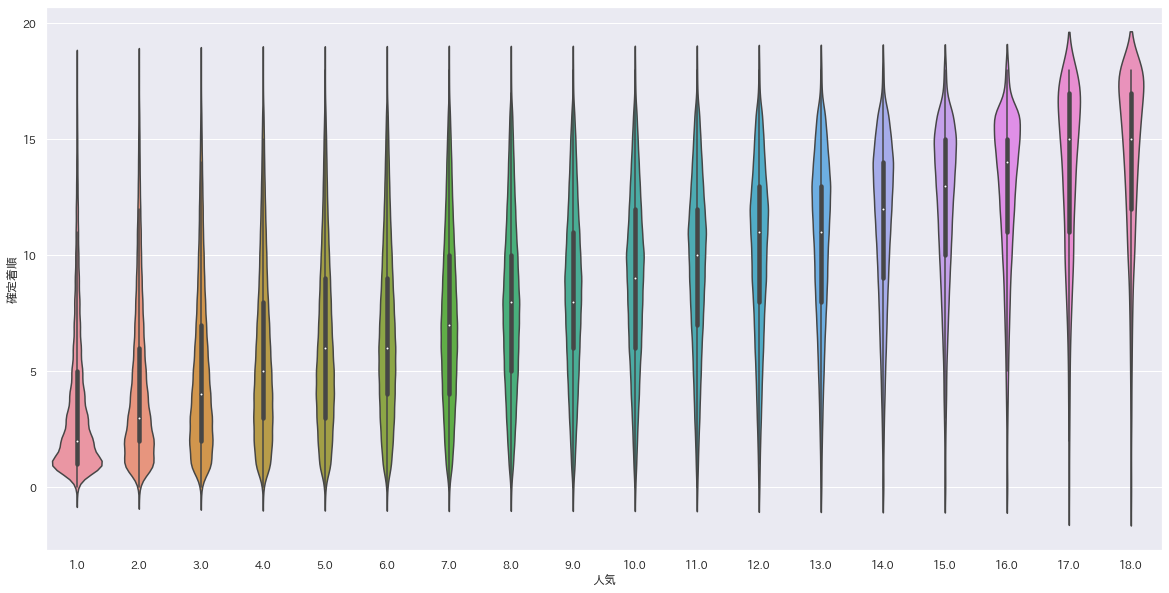

In [39]:
rcParams['figure.figsize'] = 20, 10
sns.violinplot(x='人気', y='確定着順', data=numbr)
plt.show()

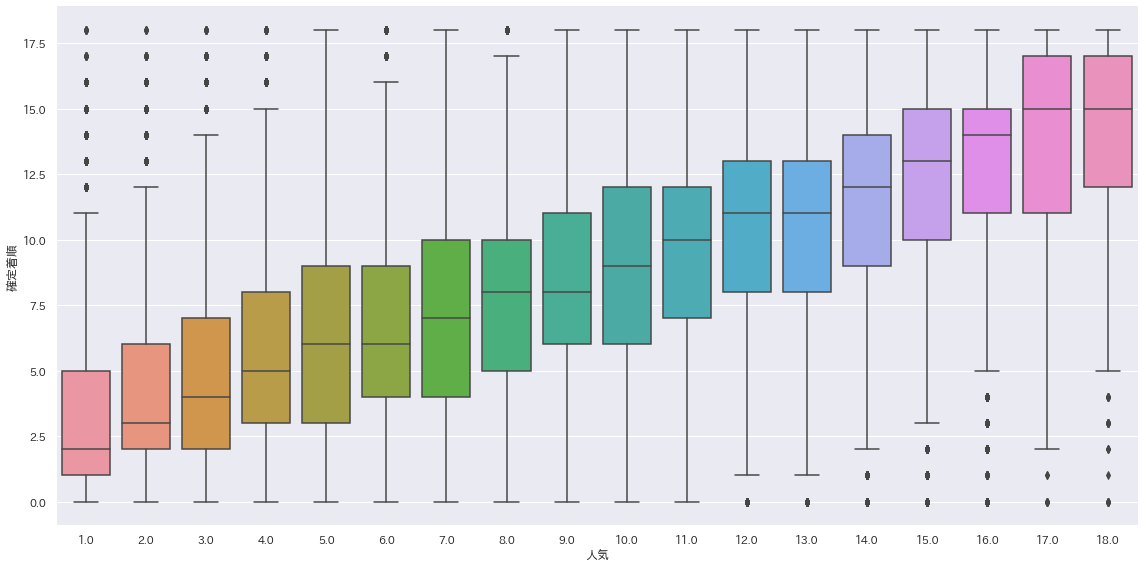

In [40]:
#sns.catplotで箱ひげ図を描く
#sns.catplot(x='人気', y='確定着順', data=numbr, kind='box', hue='頭数', height=10, aspect=2)
sns.catplot(x='人気', y='確定着順', data=numbr, kind='box', height=8, aspect=2)
#plt.show()

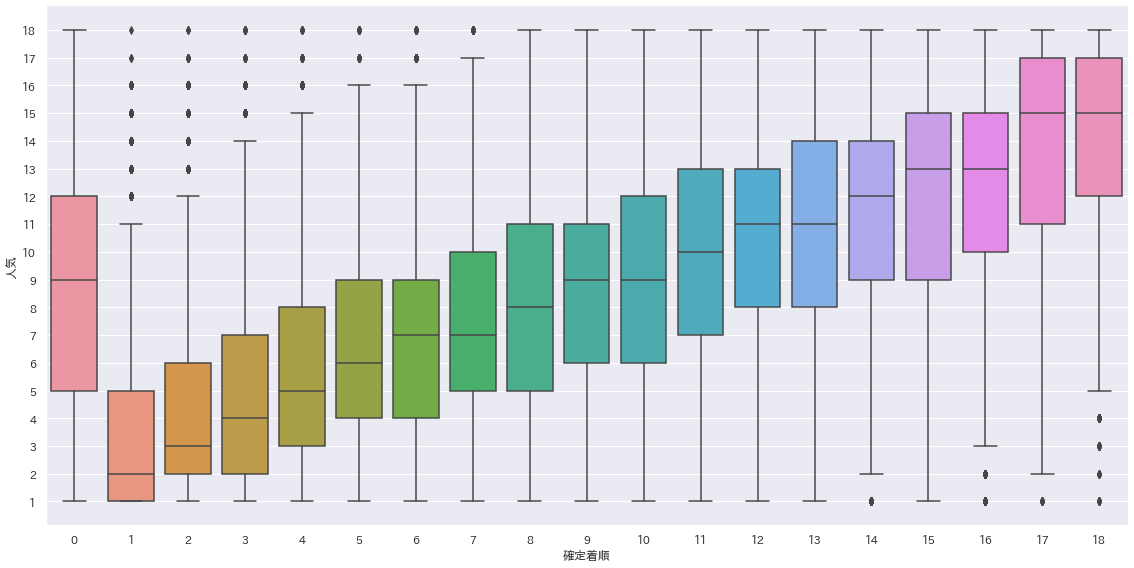

In [41]:
g = sns.catplot(x='確定着順', y='人気', data=numbr, kind='box', height=8, aspect=2)
g.set(yticks=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
#plt.show()

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(ms

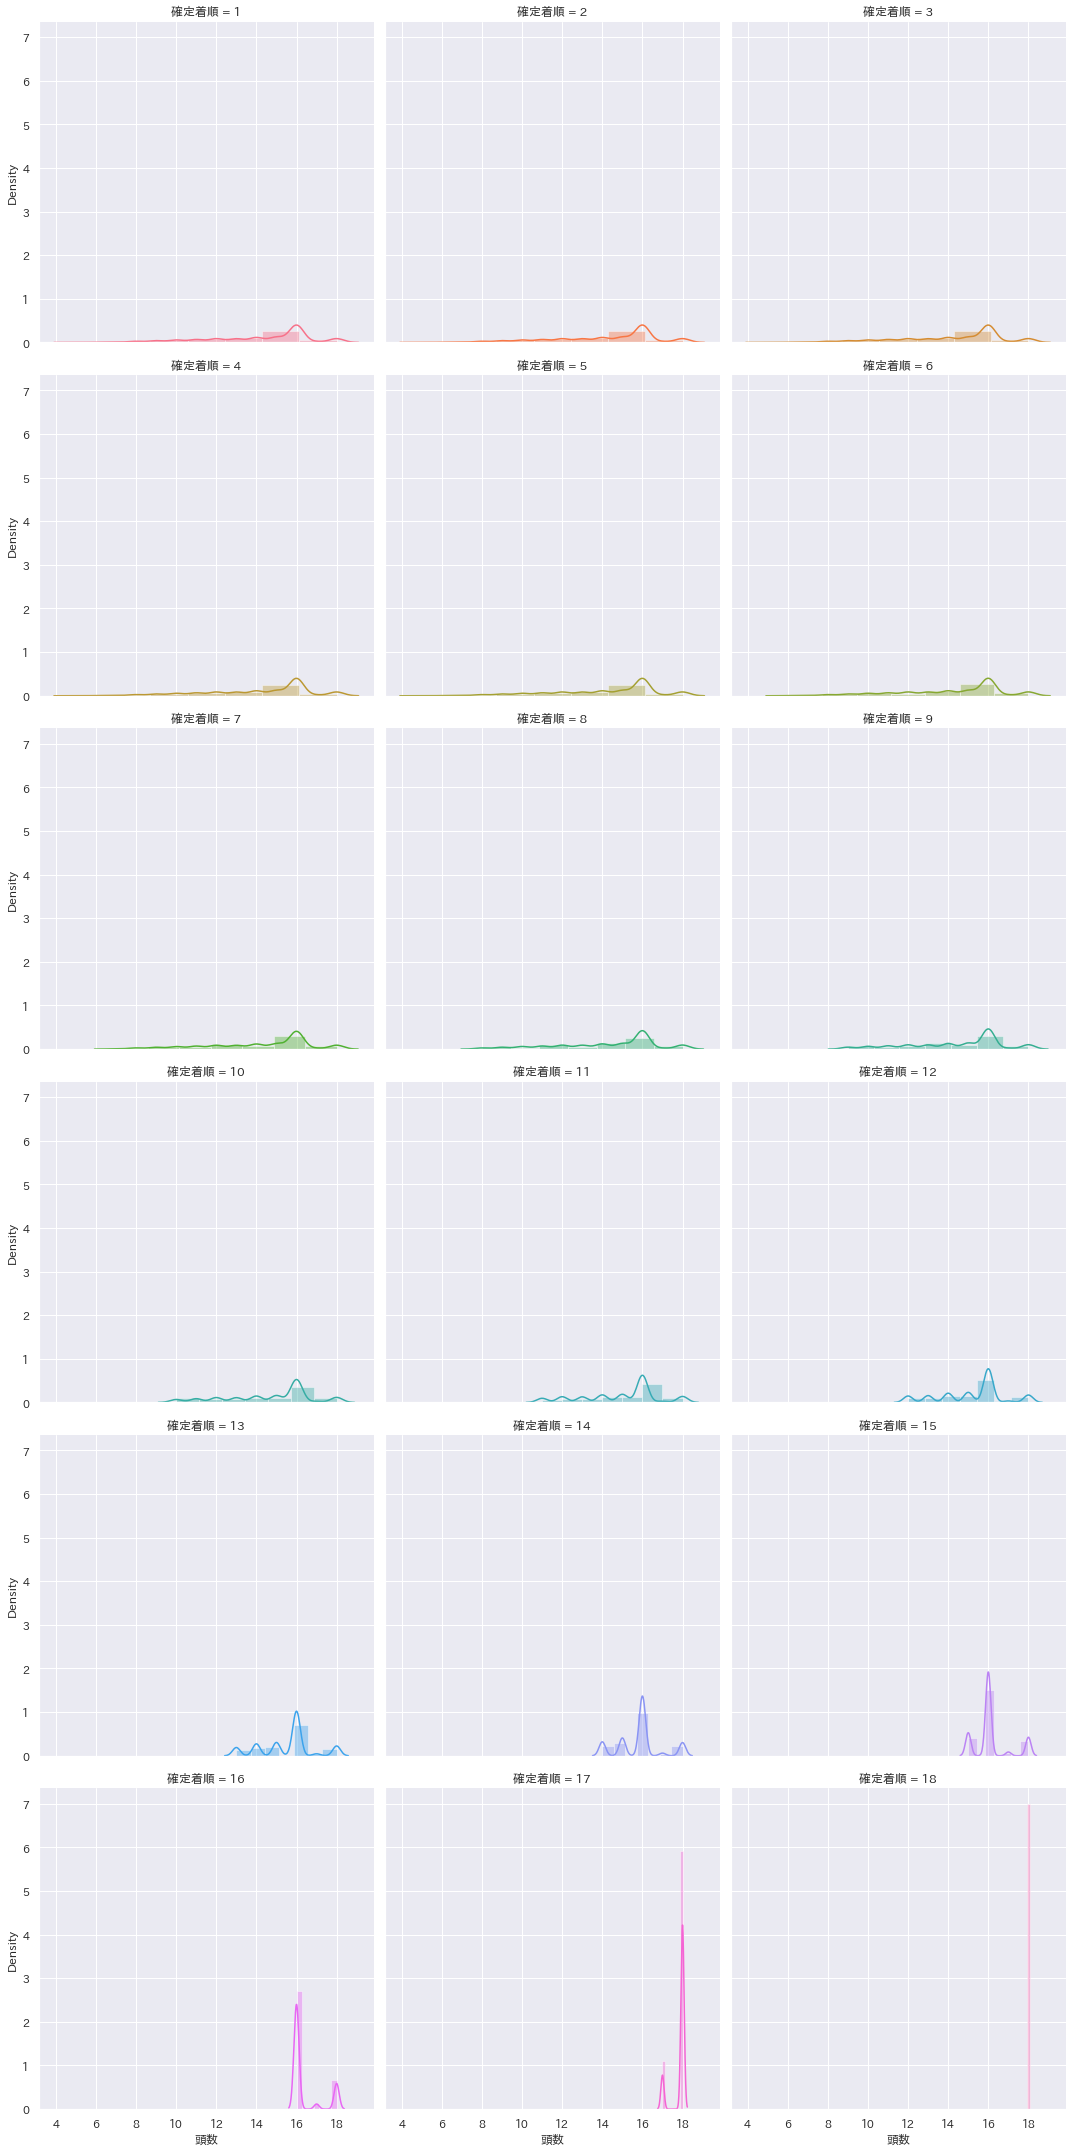

In [42]:
numbr2 = numbr[numbr['確定着順']!=0]

grid = sns.FacetGrid(numbr2, col='確定着順', hue='確定着順', col_wrap=3, size=5)
grid.map(sns.distplot, '頭数', bins=7, kde=True)
plt.show()
#numbr.info()

<AxesSubplot:title={'center':'Horse Data ペアプロット'}>

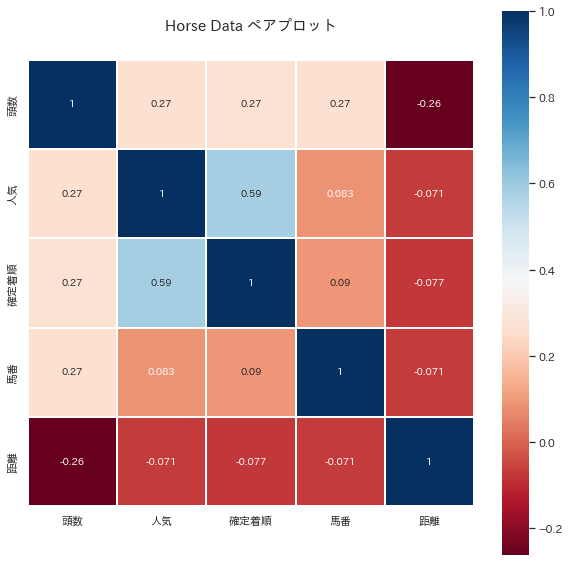

In [43]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10, 10))
plt.title('Horse Data ペアプロット', y=1.05, size=15)
sns.heatmap(numbr2.corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


In [44]:
df_horse_data = df_seiseki

In [45]:
#df_horse_data['time_diff'] = np.abs(df_horse_data['time_diff']).astype('category')
#df_horse_data['time_diff']
#__df = df_horse_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#__df.to_csv('horse_data_2015-2020_base4.csv', index=False)
#df_horse_data[['Unnamed: 0', 'Unnamed: 0.1']]

#df_horse_data['jocky_weight'].value_counts()
#df_horse_data[['jocky_code', 'jocky_ranking']].head(40)

In [46]:
# クロス集計（カテゴリ毎の出現回数・頻度を算出）
tan_o = pd.crosstab(df_horse_data['tansho_odds_i'], df_horse_data['target_rank'], margins=True).head(30)
print(tan_o)
#tan_o[0] > tan_o[10] # 2.4-2.5
#tan_o['All'] - tan_o[10] >  tan_o[10] 
#tan_o[0] + tan_o[3] + tan_o[5] > tan_o[10] # 2.4-2.5
#(tan_o[10]+tan_o[5]) / (tan_o['All'] - tan_o[10] - tan_o[5]) > 1
tan_o[10] / tan_o['All'] >= 0.7 # 単勝率 0.5: 1.5-1.6
#(tan_o[10]+tan_o[3]) / tan_o['All'] >= 0.6 # 単勝率 0.5: 2.2-2.3
#(tan_o[10]+tan_o[3]+tan_o[5]) / tan_o['All'] >= 0.6 # 単勝率 0.5: 3.9-4.0


KeyError: 'tansho_odds_i'

In [6]:
pd.crosstab(df_horse_data['adjustment_time'], df_horse_data['target_rank'], margins=True).tail(30)

KeyError: 'adjustment_time'

In [7]:
# オッズの標準偏差を求める
def each_race(df_data, threshold=0.8):
    i = 0
    
    try:
        for index in tqdm(df_data['race_id'].unique()):
            each_df = df_data.query('race_id==@index')
            #print(each_df['単勝オッズ'].var()) # 分散
            #print(each_df['単勝オッズ'].std()) # 標準偏差
            # 分位数
#            q = each_df['tan_odds'].quantile(threshold)
            #print('分位数: ', each_df['単勝オッズ'].quantile(0.8))
            # 分位数を基準として、分散を求める
#            _std = each_df.query('tan_odds<@q')['tan_odds'].std()
            #print(_std)
            #print(each_df['単勝オッズ'].describe())
#            df_data.loc[df_data['race_id']==index, 'odds_std'] = round(_std, 3)
            
            # 単勝オッズ10倍, 30倍より下が何頭いるか？
            df_data.loc[df_data['race_id']==index, 'odds_under10_tousu'] = sum( x<10 for x in each_df['tan_odds'])
            df_data.loc[df_data['race_id']==index, 'odds_under30_tousu'] = sum( x<30 for x in each_df['tan_odds'])
            
            i += 1
            #if i > 2:
            #    break


    except Exception as e:
        print('Error occured... {}, {}'.format(index, e))
        return False
    else:
        print('i= {}'.format(i))
        return True

In [8]:
#mylist = list(range(10))
#sum( x<3 for x in mylist)

#df_horse_data[['odds_under10_tousu', 'odds_under30_tousu']]

In [9]:
%%time
'''
# 約2分
each_race(df_horse_data)
#df_horse_data['odds_std']
'''
df_horse_data['odds_std'] = 0 # ダミー


CPU times: user 1.56 ms, sys: 638 µs, total: 2.19 ms
Wall time: 2.53 ms


In [10]:
#df_horse_data['odds_under10_tousu'] = df_horse_data['odds_under10_tousu'].astype(int).astype('category')
#df_horse_data['odds_under30_tousu'] = df_horse_data['odds_under30_tousu'].astype(int).astype('category')

In [11]:
import datetime

def get_week_name(df_data):
    
    df_data['week_name'] = df_data['race_id'].map(lambda x: pd.to_datetime(str(x)[:8], format="%Y%m%d").day_name())
    
    #raceid = df_data['race_id'].astype(str)
    #year = raceid.map(lambda x: int(x[:4]))
    #month = raceid.map(lambda x: int(x[4:6]))
    #day = raceid.map(lambda x: int(x[6:8]))
    #print(year[0], month[0], day[0])
    #race_day = '{}/{}/{}'.format(year, month, day)
    #date = pd.to_datetime(race_day, format="%Y/%m/%d")
    #print(date.day_name())    

    #dt = datetime.datetime(year[1], month[1], day[1])
    # 2018-01-01 00:00:00
    #print(dt.strftime('%A, %a, %B, %b'))
    #print(dt.strftime('%A'))
    # Monday, Mon, January, Jan


In [ ]:
%%time

#df_horse_data['week_name'].unique() #-> array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Friday', 'Thursday'], dtype=object)
#df_horse_data['week_name'].map(lambda x: 1 if x == 'Sunday' else 0)
get_week_name(df_horse_data)
# 日曜日は1、以外は0 に設定する(日曜日に強い馬が走っていると思う)
df_horse_data['week_name'] = df_horse_data['week_name'].map(lambda x: 1 if x == 'Sunday' else 0)
df_horse_data['week_name'] = df_horse_data['week_name'].astype('category')